In [1]:
import matplotlib.pyplot as plt
import numpy as np
from warnings import filterwarnings
import torch
import torchkbnufft as tkbn
import scipy.io
import os
import napari

In [2]:
fov = 96
im_size = (fov,fov,fov)
grid_size = (tuple(int(dim * 2) for dim in im_size))
print(im_size,grid_size)

(96, 96, 96) (192, 192, 192)


In [36]:
# Load the .mat file
coil_data = scipy.io.loadmat('s_te/s_te_coil_1.mat')
traj_data = scipy.io.loadmat('radial_3d_correct_pi.mat')

# Check keys in the file to find the variable name
print(coil_data.keys())  
print(traj_data.keys())  

dict_keys(['__header__', '__version__', '__globals__', 'flattened_data'])
dict_keys(['__header__', '__version__', '__globals__', 'p_pi'])


In [38]:
# Extract the matrix (replace 'output_matrix' with the actual key from .mat file)
coil_1_matrix = coil_data['flattened_data']  # Shape: (224, 28952, 3)

# Convert to NumPy array
kdata = np.array(coil_1_matrix)

# Print shape to verify
print("Loaded shape:", kdata.shape)

# Extract the matrix (replace 'output_matrix' with the actual key from .mat file)
traj_matrix = traj_data['p_pi']  # Shape: (224, 28952, 3)

# Convert to NumPy array
ktraj = np.array(traj_matrix)

# Print shape to verify
print("Loaded shape:", ktraj.shape)

Loaded shape: (1, 6485248)
Loaded shape: (3, 6485248)


In [39]:
# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the ktraj and kdata tensors to the selected device
ktraj = torch.tensor(ktraj, dtype=torch.float32).to(device)  # Shape: (num_samples, 3)
kdata = torch.tensor(kdata, dtype=torch.complex64).to(device) 

# Reshape kdata into [1, 1, num_samples]
kdata = kdata.view(1, 1, -1)  # Adds batch size and coil dimensions

# Move it to the correct device (e.g., CUDA or CPU)
kdata = kdata.to(device)

# Print the shapes and device of the tensors
print('ktraj shape: {}'.format(ktraj.shape))
print('kdata shape: {}'.format(kdata.shape))

# Check the device of both tensors
print("ktraj device:", ktraj.device)
print("kdata device:", kdata.device)


ktraj shape: torch.Size([3, 6485248])
kdata shape: torch.Size([1, 1, 6485248])
ktraj device: cpu
kdata device: cpu


In [40]:
# Initialize the adjoint NUFFT operator
adjnufft_ob = tkbn.KbNufftAdjoint(
    im_size=im_size,
    grid_size=grid_size,
).to(kdata.device)  # Move to the same device as kdata_torch (CPU or GPU)

print(adjnufft_ob)


KbNufftAdjoint
----------------------------------------
buffers
	tensor: table_0, shape: (6145,)
	tensor: table_1, shape: (6145,)
	tensor: table_2, shape: (6145,)
	tensor: im_size, shape: (3,)
	tensor: grid_size, shape: (3,)
	tensor: n_shift, shape: (3,)
	tensor: numpoints, shape: (3,)
	tensor: offsets, shape: (216, 3)
	tensor: table_oversamp, shape: (3,)
	tensor: order, shape: (3,)
	tensor: alpha, shape: (3,)
	tensor: scaling_coef, shape: (96, 96, 96)



In [41]:
# adjnufft back
# method 1: no density compensation (blurry image)
#image_blurry = adjnufft_ob(kdata, ktraj)


In [42]:
# method 2: use density compensation
dcomp = tkbn.calc_density_compensation_function(ktraj=ktraj, im_size=im_size)
image_sharp = adjnufft_ob(kdata * dcomp, ktraj)

48


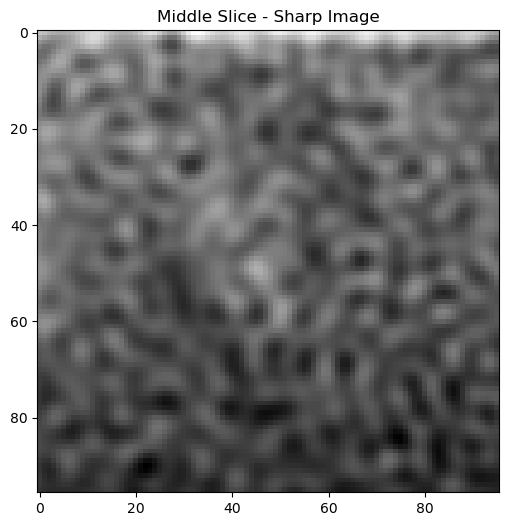

In [25]:
#image_blurry_numpy = np.squeeze(image_blurry.cpu().numpy())
image_sharp_numpy = np.squeeze(image_sharp.cpu().numpy())

#print(image_blurry_numpy.shape)

# Get the middle slice along the first axis (e.g., if shape is [1, 1, num_samples, height, width])
slice_idx = image_sharp_numpy.shape[0] // 2
slice_idx = 48
print(slice_idx)

# Extract the middle slice (assuming it's the 4th dimension in [batch, coil, num_samples, height, width])
#middle_blurry_slice = np.abs(image_blurry_numpy[slice_idx, :,:])
middle_sharp_slice = np.abs(image_sharp_numpy[:,:,slice_idx])

# # Plot the middle slices
# fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# axes[0].imshow(middle_blurry_slice, cmap='gray')
# axes[0].set_title("Middle Slice - Blurry Image")

# axes[1].imshow(middle_sharp_slice, cmap='gray')
# axes[1].set_title("Middle Slice - Sharp Image")

# # Save both figures
# fig.savefig("middle_slice_comparison.png", bbox_inches='tight')

# Optionally, save each plot individually (for each slice)
# fig_blurry, ax_blurry = plt.subplots(figsize=(6, 6))
# ax_blurry.imshow(middle_blurry_slice, cmap='gray')
# ax_blurry.set_title("Middle Slice - Blurry Image")
# fig_blurry.savefig("middle_blurry_slice.png", bbox_inches='tight')

fig_sharp, ax_sharp = plt.subplots(figsize=(6, 6))
ax_sharp.imshow(middle_sharp_slice, cmap='gray')
ax_sharp.set_title("Middle Slice - Sharp Image")

folder_name = "saved_images_s_te"

# Create the folder if it doesn't exist
os.makedirs(folder_name, exist_ok=True)

fig_sharp.savefig(os.path.join(folder_name, f"middle_sharp_slice.png"), bbox_inches='tight')

data_f = "images_s_te"

# Create the folder if it doesn't exist
os.makedirs(data_f, exist_ok=True)
reshaped = np.reshape(image_sharp_numpy, (-1, fov))
#reshaped = image_sharp_numpy.reshape(-1, 3)
file_path = os.path.join(data_f, f'imagesharp.txt')
np.savetxt(file_path, reshaped, fmt='%.6f')

plt.show()

In [21]:

# Define the folder where the file is saved
data_f = "images_s_te"
# Define the file path
num = 33
restored_image = np.zeros((fov, fov, fov), dtype=np.float32)

for x in range(1,num):
    file_path = os.path.join(data_f, f'imagesharp{x}.txt')
    loaded_data = np.loadtxt(file_path, dtype=np.complex64)

    # Reshape it back to the original format
    reshaped_image = loaded_data.reshape(fov,fov,fov)  # Adjust shape if needed
    restored_image = restored_image + abs(reshaped_image)**2


loaded_data = np.sqrt(restored_image)   
print(loaded_data.shape)


(96, 96, 96)


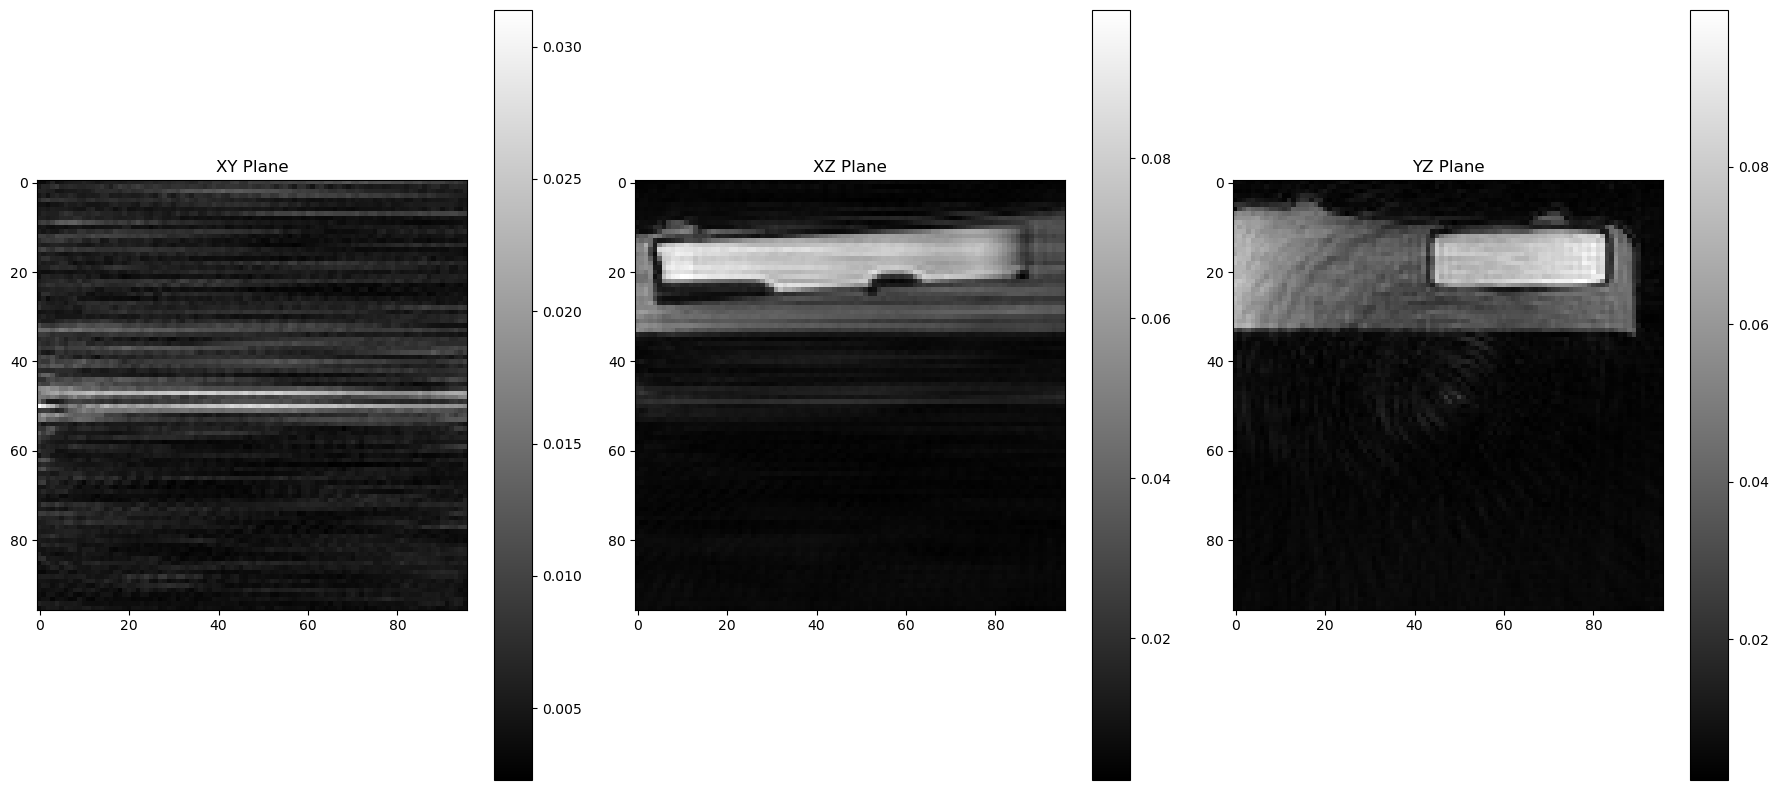

In [22]:
slice_idx = 48
# Extracting different middle slices
middle_sharp_slice_1 = (loaded_data[slice_idx, :, :])  # XY plane
middle_sharp_slice_2 = (loaded_data[:, slice_idx, :])  # XZ plane
middle_sharp_slice_3 = (loaded_data[:, :, slice_idx])  # YZ plane

fig, axes = plt.subplots(1, 3, figsize=(18, 8))

# Plot each slice
titles = ["XY Plane", "XZ Plane", "YZ Plane"]
slices = [middle_sharp_slice_1, middle_sharp_slice_2, middle_sharp_slice_3]

for ax, data, title in zip(axes, slices, titles):
    im = ax.imshow(data, cmap='gray')
    ax.set_title(title)
    fig.colorbar(im, ax=ax)

plt.tight_layout()
# fig.savefig("middle_sharp_slices.png", bbox_inches='tight')
plt.show()

# Save it as a .mat file
scipy.io.savemat("im_data_ste.mat", {"image_full_3d_ste": loaded_data})


In [ ]:
# Launch napari viewer
viewer = napari.Viewer()
viewer.add_image(volume, colormap='gray', rendering='mip')  # MIP = Maximum Intensity Projection
napari.run()

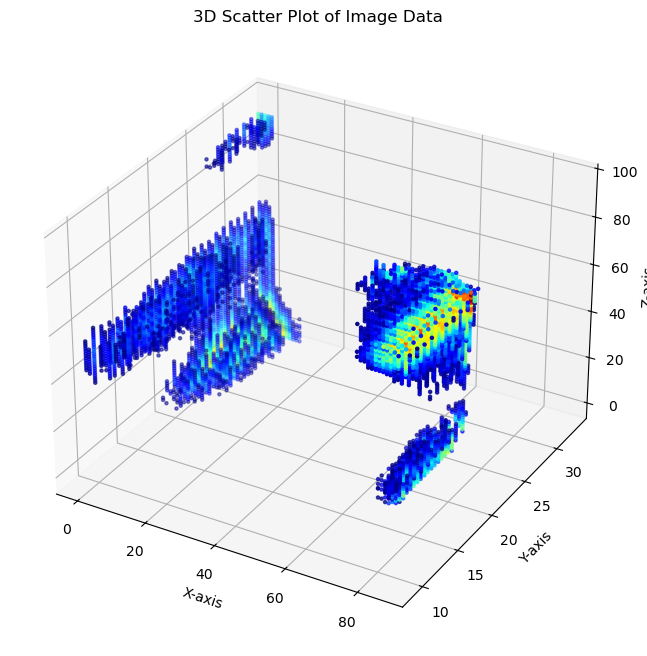

In [7]:
# Use magnitude values for visualization
data_to_plot = np.abs(loaded_data)

# Create a figure and 3D axis
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Define grid points
x, y, z = np.meshgrid(np.arange(fov), np.arange(fov), np.arange(fov))

# Scatter plot of points above a threshold
threshold = np.percentile(data_to_plot, 99)  # Adjust based on visibility
mask = data_to_plot > threshold
ax.scatter(x[mask], y[mask], z[mask], c=data_to_plot[mask], cmap='jet', marker='.')

ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
plt.title("3D Scatter Plot of Image Data")

plt.show()

In [38]:
import ipyvolume as ipv

# Normalize the data
data_normalized = (np.abs(reshaped_data) - np.min(reshaped_data)) / np.ptp(reshaped_data)

# Show 3D volume
ipv.quickvolshow(data_normalized, level=[0.1, 0.5, 0.9], opacity=0.03)
ipv.show()

AttributeError: partially initialized module 'ipyvolume' from '/rds/general/user/ip620/home/miniforge3/envs/fyp/lib/python3.13/site-packages/ipyvolume/__init__.py' has no attribute '_version' (most likely due to a circular import)